# –î–æ–º–∞—à–Ω–µ–µ –∑–∞–¥–∞–Ω–∏–µ –∫ —É—Ä–æ–∫—É 3: –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–µ—Ç–∏

## –¶–µ–ª—å –∑–∞–¥–∞–Ω–∏—è
–ò–∑—É—á–∏—Ç—å –≤–ª–∏—è–Ω–∏–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã—Ö —Å–µ—Ç–µ–π –Ω–∞ –∫–∞—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏, –ø—Ä–æ–≤–µ—Å—Ç–∏ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è–º–∏ –º–æ–¥–µ–ª–µ–π.

## –ó–∞–¥–∞–Ω–∏–µ 1: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –≥–ª—É–±–∏–Ω–æ–π —Å–µ—Ç–∏ (30 –±–∞–ª–ª–æ–≤)

### –ò–º–ø–æ—Ä—Ç–∏—Ä—É–µ–º –Ω—É–∂–Ω—ã–µ –º–æ–¥—É–ª–∏

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import logging
import time
import os
import numpy as np
import seaborn as sns
import json

### –ó–∞–¥–∞–¥–∏–º –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –≥–∏–ø–µ—Ä–ø–∞—Ä–∞–º–µ—Ç—Ä—ã

In [4]:
torch.set_num_threads(1)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True

BATCH_SIZE = 256
EPOCHS = 50
LEARNING_RATE = 1e-3
INPUT_DIM = 28*28
OUTPUT_DIM = 10

Using device: cuda


### –ó–∞–≥—Ä—É–∑–∏–º MNIST

In [7]:
def get_data_loaders(train_subset_size=None, test_subset_size=None): # –î–æ–±–∞–≤–∏–ª–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è —Ä–∞–∑–º–µ—Ä–∞ –ø–æ–¥–Ω–∞–±–æ—Ä–∞
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    train_dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)

    if train_subset_size is not None:
        if train_subset_size > len(train_dataset):
            print(f"Warning: train_subset_size ({train_subset_size}) is larger than actual train_dataset size ({len(train_dataset)}). Using full dataset.")
        else:
            indices = torch.randperm(len(train_dataset))[:train_subset_size] # –°–ª—É—á–∞–π–Ω—ã–µ –∏–Ω–¥–µ–∫—Å—ã
            train_dataset = Subset(train_dataset, indices)
            print(f"Using a subset of {len(train_dataset)} training samples.")


    if test_subset_size is not None:
        if test_subset_size > len(test_dataset):
            print(f"Warning: test_subset_size ({test_subset_size}) is larger than actual test_dataset size ({len(test_dataset)}). Using full dataset.")
        else:
            indices = torch.randperm(len(test_dataset))[:test_subset_size] # –°–ª—É—á–∞–π–Ω—ã–µ –∏–Ω–¥–µ–∫—Å—ã
            test_dataset = Subset(test_dataset, indices)
            print(f"Using a subset of {len(test_dataset)} test samples.")

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
    return train_loader, test_loader

### –í–∑—è–ª –∫–ª–∞—Å—Å –¥–ª—è FCN —Å —É—Ä–æ–∫–∞

In [8]:
class FullyConnectedModel(nn.Module):
    def __init__(self, config_path=None, input_size=None, num_classes=None, **kwargs):
        super().__init__()

        if config_path:
            self.config = self.load_config(config_path)
        else:
            self.config = kwargs

        self.input_size = input_size or self.config.get('input_size', 784)
        self.num_classes = num_classes or self.config.get('num_classes', 10)

        self.layers = self._build_layers()

    def load_config(self, config_path):
        with open(config_path, 'r') as f:
            return json.load(f)

    def _build_layers(self):
        layers = []
        prev_size = self.input_size

        layer_config = self.config.get('layers', [])

        for layer_spec in layer_config:
            layer_type = layer_spec['type']

            if layer_type == 'linear':
                out_size = layer_spec['size']
                layers.append(nn.Linear(prev_size, out_size))
                prev_size = out_size

            elif layer_type == 'relu':
                layers.append(nn.ReLU())

            elif layer_type == 'sigmoid':
                layers.append(nn.Sigmoid())

            elif layer_type == 'tanh':
                layers.append(nn.Tanh())

            elif layer_type == 'dropout':
                rate = layer_spec.get('rate', 0.5)
                layers.append(nn.Dropout(rate))

            elif layer_type == 'batch_norm':
                layers.append(nn.BatchNorm1d(prev_size))

            elif layer_type == 'layer_norm':
                layers.append(nn.LayerNorm(prev_size))

        layers.append(nn.Linear(prev_size, self.num_classes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)

## –§—É–Ω–∫—Ü–∏—è –¥–ª—è —Ä–∞—Å—Å—á–µ—Ç–∞ accuracy –∏ loss

In [9]:
def evaluate_model(model, loader, criterion):
    model.eval()
    correct, total, loss_sum = 0, 0, 0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            correct += (outputs.argmax(1) == y).sum().item()
            total += y.size(0)
            loss_sum += loss.item()
    return correct/total, loss_sum/len(loader)

### –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—É—á–µ–Ω–∏—è –º–æ–¥–µ–ª–∏

In [10]:
def train_model(model, train_loader, test_loader, num_epochs, optimizer, criterion, tag):
    train_acc, test_acc, train_loss, test_loss = [], [], [], []
    for epoch in range(num_epochs):
        model.train()
        correct, total, loss_epoch = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()

            loss_epoch += loss.item() * y.size(0)
            preds = outputs.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        acc_train = correct / total
        train_loss.append(loss_epoch / total)
        train_acc.append(acc_train)

        acc_test, loss_test = evaluate_model(model, test_loader, criterion)
        test_loss.append(loss_test)
        test_acc.append(acc_test)

        logging.info(f"[{tag}] Epoch {epoch+1}/{num_epochs} | Train Acc: {acc_train:.4f} | Test Acc: {acc_test:.4f}")
    return train_acc, test_acc, train_loss, test_loss


### –§—É–Ω–∫—Ü–∏—è –¥–ª—è –≤—ã–≤–æ–¥–∞ –≥—Ä–∞—Ñ–∏–∫–∞ –º–µ—Ç—Ä–∏–∫ –¥–ª—è test –∏ train –≤—ã–±–æ—Ä–æ–∫

In [11]:
def plot_curves(train_metric, test_metric, ylabel, title):
    plt.figure(figsize=(8,5))
    plt.plot(train_metric, label='Train')
    plt.plot(test_metric, label='Test')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

### 1.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Ä–∞–∑–Ω–æ–π –≥–ª—É–±–∏–Ω—ã (15 –±–∞–ª–ª–æ–≤)
```python
# –°–æ–∑–¥–∞–π—Ç–µ –∏ –æ–±—É—á–∏—Ç–µ –º–æ–¥–µ–ª–∏ —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–ª–æ–µ–≤:
# - 1 —Å–ª–æ–π (–ª–∏–Ω–µ–π–Ω—ã–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä)
# - 2 —Å–ª–æ—è (1 —Å–∫—Ä—ã—Ç—ã–π)
# - 3 —Å–ª–æ—è (2 —Å–∫—Ä—ã—Ç—ã—Ö)
# - 5 —Å–ª–æ–µ–≤ (4 —Å–∫—Ä—ã—Ç—ã—Ö)
# - 7 —Å–ª–æ–µ–≤ (6 —Å–∫—Ä—ã—Ç—ã—Ö)
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train –∏ test
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –∫—Ä–∏–≤—ã–µ –æ–±—É—á–µ–Ω–∏—è
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
```
### 1.2 –ê–Ω–∞–ª–∏–∑ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è (15 –±–∞–ª–ª–æ–≤)
```python
# –ò—Å—Å–ª–µ–¥—É–π—Ç–µ –≤–ª–∏—è–Ω–∏–µ –≥–ª—É–±–∏–Ω—ã –Ω–∞ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ:
# - –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥—Ä–∞—Ñ–∏–∫–∏ train/test accuracy –ø–æ —ç–ø–æ—Ö–∞–º
# - –û–ø—Ä–µ–¥–µ–ª–∏—Ç–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é –≥–ª—É–±–∏–Ω—É –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞
# - –î–æ–±–∞–≤—å—Ç–µ Dropout –∏ BatchNorm, —Å—Ä–∞–≤–Ω–∏—Ç–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ, –∫–æ–≥–¥–∞ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ
```

In [21]:
def depth_experiments(train_loader, test_loader):
    depths = [0, 1, 2, 4, 6]
    hidden_dim = 256
    criterion = nn.CrossEntropyLoss()
    final_accuracies = []

    best_test_accuracies_per_depth = []

    for num_hidden in depths:
        tag = f"depth_{num_hidden}"
        logging.info(f"--- Running experiment for {tag} ---")
        layers = []
        for _ in range(num_hidden):
            layers.extend([
                {"type": "linear", "size": hidden_dim},
                {"type": "relu"},
            ])
        config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
        model = FullyConnectedModel(**config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

        start = time.time()
        train_acc, test_acc, train_loss, test_loss = train_model(
            model, train_loader, test_loader, EPOCHS, optimizer, criterion, tag)
        elapsed = time.time() - start
        logging.info(f"{tag} | Total Training Time={elapsed:.2f}s")
        plot_curves(train_acc, test_acc, 'Accuracy', f'Train/Test Accuracy ({tag})')

        max_test_acc = max(test_acc)
        best_test_accuracies_per_depth.append((num_hidden, max_test_acc))

        final_accuracies.append(test_acc[-1]) 

    print("\n=== Summary of Best Test Accuracies per Depth ===")
    for depth, acc in best_test_accuracies_per_depth:
        print(f"For depth {depth}: the best acc is {acc:.4f}")

    avg_acc = np.mean(final_accuracies)
    print(f"\n[CHECK] Depth experiments avg final test accuracy: {avg_acc:.4f}")
    best_test_accuracies_per_depth_drop=[]
    for num_hidden in depths:
        tag = f"overfit_{num_hidden}"
        layers = []
        
        for _ in range(num_hidden):
            layers.extend([
                {"type": "linear", "size": hidden_dim},
                {"type": "batch_norm"},
                {"type": "relu"},
                {"type": "dropout", "rate": 0.3},
            ])
        config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
        model = FullyConnectedModel(**config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        train_acc, test_acc, _, _ = train_model(
            model, train_loader, test_loader, EPOCHS, optimizer, criterion, tag)
        plot_curves(train_acc, test_acc, 'Accuracy', f'Train/Test Accuracy (Dropout+BN {tag})')
        max_test_acc_drop = max(test_acc)
        best_test_accuracies_per_depth_drop.append((num_hidden, max_test_acc_drop))
    print("\n=== Summary of Best Test Accuracies per Depth with Dropout + Batchnorm ===")
    for depth, acc in best_test_accuracies_per_depth_drop:
        print(f"For depth {depth}: the best acc is {acc:.4f}")

### –ó–∞–ø—É—Å–∫–∞–µ–º —ç–∫—Å–ø–µ—Ä–µ–º–µ–Ω—Ç 1
### –î–ª—è —É—Å–∫–æ—Ä–µ–Ω–∏—è –æ–±—É—á–µ–Ω–∏—è –∏—Å–ø–æ–ª—å–∑–æ–≤–∞–ª 10000 –ø—Ä–∏–º–µ—Ä–æ–≤ train –∏ 2000 –ø—Ä–∏–º–µ—Ä–æ–≤ test

Using a subset of 10000 training samples.
Using a subset of 2000 test samples.
=== Starting Depth Experiments ===


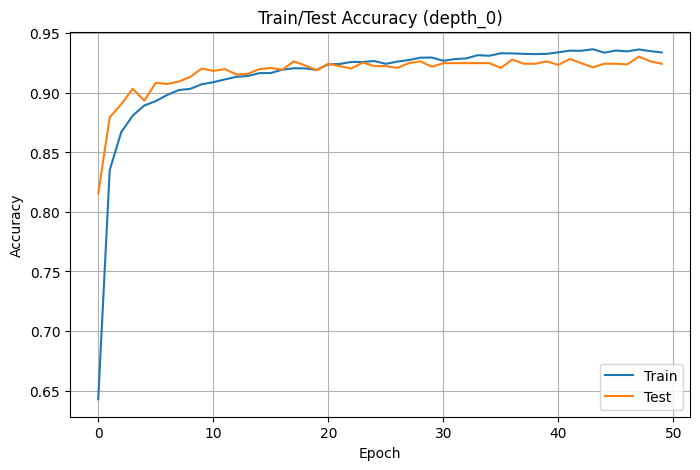

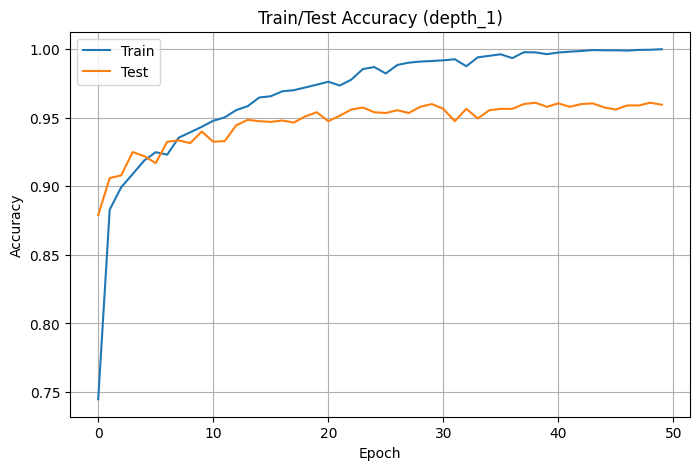

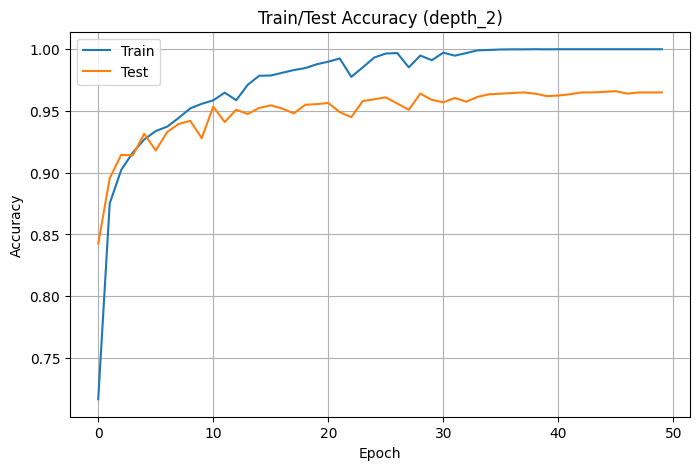

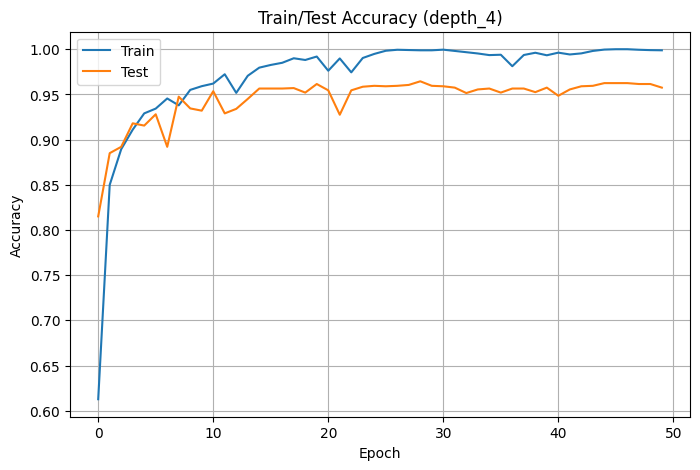

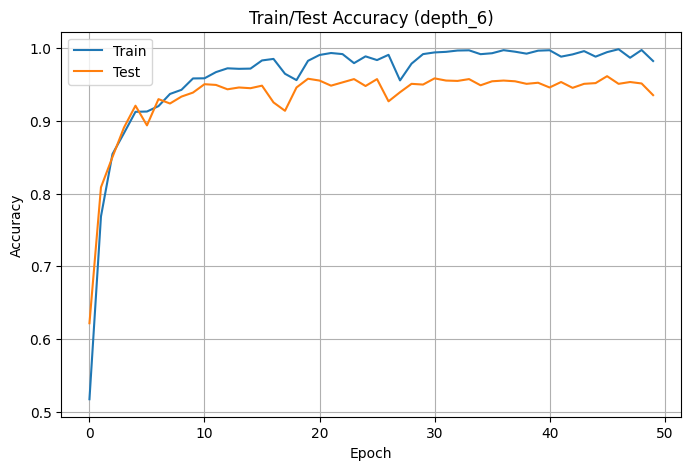


=== Summary of Best Test Accuracies per Depth ===
For depth 0: the best acc is 0.9305
For depth 1: the best acc is 0.9610
For depth 2: the best acc is 0.9660
For depth 4: the best acc is 0.9645
For depth 6: the best acc is 0.9610

[CHECK] Depth experiments avg final test accuracy: 0.9483


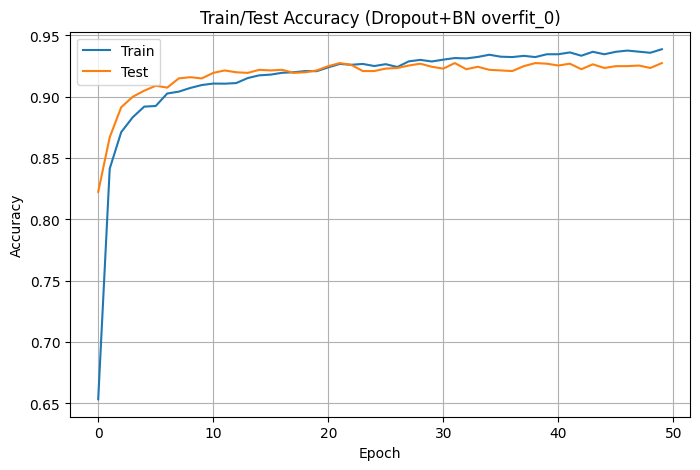

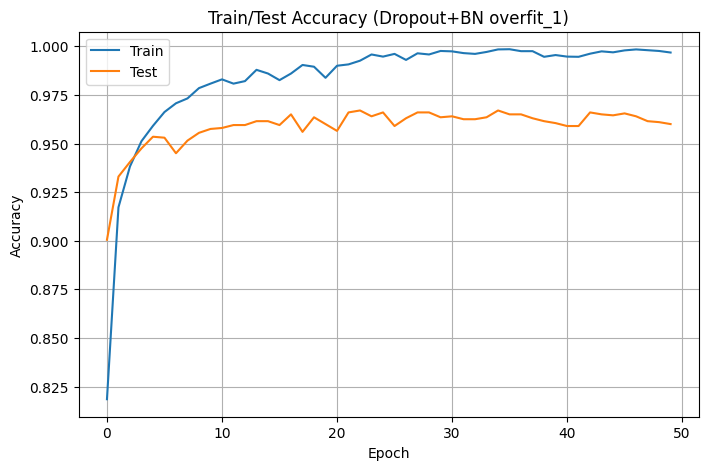

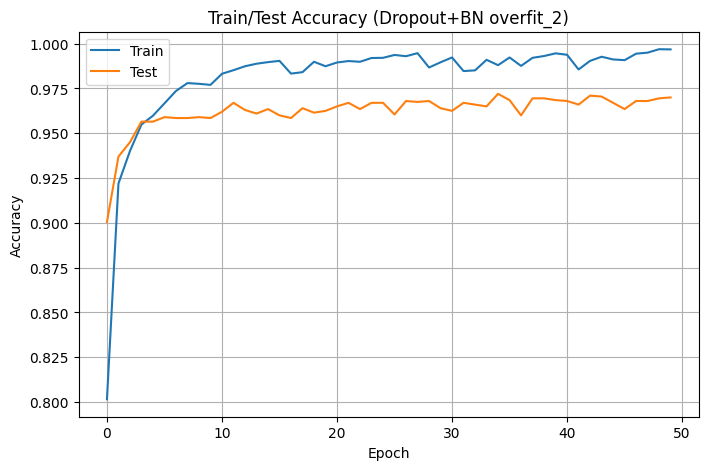

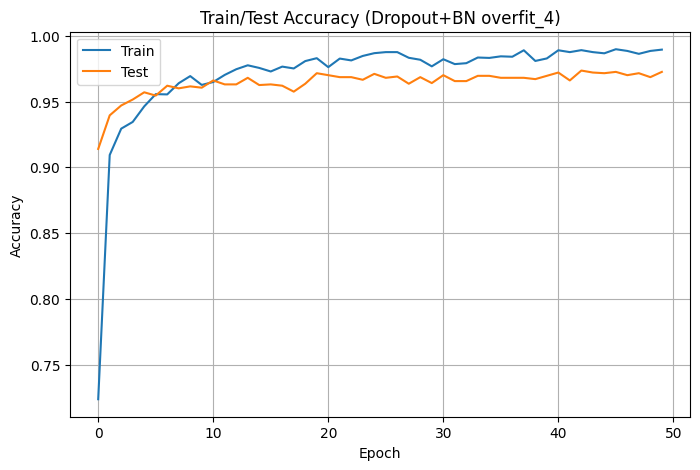

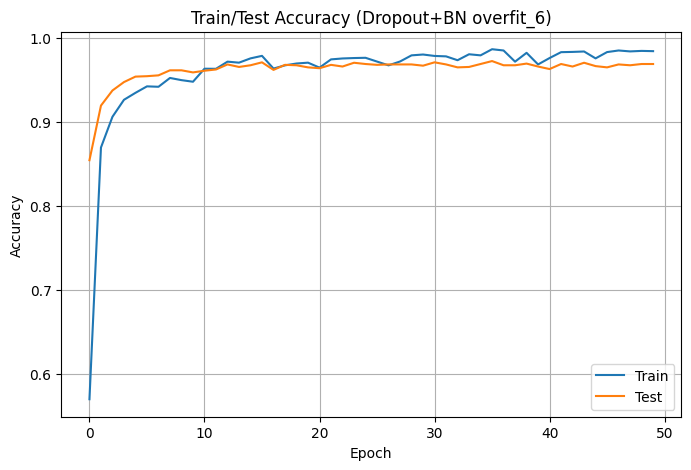


=== Summary of Best Test Accuracies per Depth with Dropout + Batchnorm ===
For depth 0: the best acc is 0.9275
For depth 1: the best acc is 0.9670
For depth 2: the best acc is 0.9720
For depth 4: the best acc is 0.9735
For depth 6: the best acc is 0.9720


In [22]:
train_loader, test_loader = get_data_loaders(train_subset_size=10000, test_subset_size=2000)
print("=== Starting Depth Experiments ===")
depth_experiments(train_loader, test_loader)

### –ò–Ω—Ñ–æ—Ä–º–∞—Ü–∏—è –∏–∑ –≥—Ä–∞—Ñ–∏–∫–æ–≤:
1. –í –æ–±—â–µ–º –ø—Ä–∏ —É–≤–µ–ª–∏—á–µ–Ω–∏–∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–µ–≤ —É–≤–µ–ª–∏—á–∏–≤–∞–µ—Ç—Å—è accuracy
2. –ü—Ä–∏ —É–≤–µ–ª–∏—á–µ–Ω–∏–∏ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ —Å–ª–æ–µ–≤ –Ω–µ–º–Ω–æ–≥–æ —Ä–∞—Å—Ç–µ—Ç –≤—Ä–µ–º—è —Ä–∞–±–æ—Ç—ã.
3. –ü—Ä–∏ –¥–æ—Å—Ç–∏–∂–µ–Ω–∏–∏ 20-30 —ç–ø–æ—Ö accuracy –Ω–∞ test —Å—Ç–∞–Ω–æ–≤–∏—Ç—Å—è –ø—Ä–∏–º–µ—Ä–Ω–æ –ø–∞—Ä–∞–ª–ª–µ–ª—å–Ω–æ x –æ—Å–∏ (–Ω–µ —Ä–∞—Å—Ç–µ—Ç) –∑–Ω–∞—á–∏—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω–æ 20-30 —ç–ø–æ—Ö
4. –ò—Å–ø–æ–ª—å–∑–æ–≤–∞–Ω–∏–µ Dropout –∏ Batchnorm –¥–∞–ª–æ –Ω–µ–±–æ–ª—å—à–æ–π –ø—Ä–∏—Ä–æ—Å—Ç accuracy ~ 0.01
5. –ò—Ç–æ–≥ –¥–ª—è batch = 256, LEARNING_RATE = 1e-3 –≥–∞—Ä–º–æ–Ω–∏—á–Ω–æ–µ —Ä–µ—à–µ–Ω–∏–µ –∏–∑ –∏—Å—Å–ª–µ–¥—É–µ–º—ã—Ö –ø–æ —Å–∫–æ—Ä–æ—Å—Ç–∏ –∏ accuracy –∏ —ç–ø–æ—Ö–∞–º —ç—Ç–æ —Ä–µ—à–µ–Ω–∏–µ —Å –≥–ª—É–±–∏–Ω–æ–π 2 –∏ 20 —ç–ø–æ—Ö–∞–º–∏.

## –ó–∞–¥–∞–Ω–∏–µ 2: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å —à–∏—Ä–∏–Ω–æ–π —Å–µ—Ç–∏ (25 –±–∞–ª–ª–æ–≤)

### 2.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Ä–∞–∑–Ω–æ–π —à–∏—Ä–∏–Ω—ã (15 –±–∞–ª–ª–æ–≤)
```python
# –°–æ–∑–¥–∞–π—Ç–µ –º–æ–¥–µ–ª–∏ —Å —Ä–∞–∑–ª–∏—á–Ω–æ–π —à–∏—Ä–∏–Ω–æ–π —Å–ª–æ–µ–≤:
# - –£–∑–∫–∏–µ —Å–ª–æ–∏: [64, 32, 16]
# - –°—Ä–µ–¥–Ω–∏–µ —Å–ª–æ–∏: [256, 128, 64]
# - –®–∏—Ä–æ–∫–∏–µ —Å–ª–æ–∏: [1024, 512, 256]
# - –û—á–µ–Ω—å —à–∏—Ä–æ–∫–∏–µ —Å–ª–æ–∏: [2048, 1024, 512]
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –ü–æ–¥–¥–µ—Ä–∂–∏–≤–∞–π—Ç–µ –æ–¥–∏–Ω–∞–∫–æ–≤—É—é –≥–ª—É–±–∏–Ω—É (3 —Å–ª–æ—è)
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ç–æ—á–Ω–æ—Å—Ç—å –∏ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
```

### 2.2 –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã (10 –±–∞–ª–ª–æ–≤)
```python
# –ù–∞–π–¥–∏—Ç–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É:
# - –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ grid search –¥–ª—è –ø–æ–∏—Å–∫–∞ –ª—É—á—à–µ–π –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏
# - –ü–æ–ø—Ä–æ–±—É–π—Ç–µ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Å—Ö–µ–º—ã –∏–∑–º–µ–Ω–µ–Ω–∏—è —à–∏—Ä–∏–Ω—ã (—Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ, —Å—É–∂–µ–Ω–∏–µ, –ø–æ—Å—Ç–æ—è–Ω–Ω–∞—è)
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ –≤–∏–¥–µ heatmap

In [26]:
def width_experiments(train_loader, test_loader):
    widths = {
        'narrow': [64, 32, 16],
        'medium': [256, 128, 64],
        'wide': [1024, 512, 256],
        'very_wide': [2048, 1024, 512],
    }
    criterion = nn.CrossEntropyLoss()
    results = []

    for tag, width_list in widths.items():
        logging.info(f"=== Running width experiment: {tag} ===")
        layers = []
        prev_size = INPUT_DIM
        for size in width_list:
            layers.extend([
                {"type": "linear", "size": size},
                {"type": "relu"},
            ])
            prev_size = size
        config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
        model = FullyConnectedModel(**config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
        start = time.time()
        train_acc, test_acc, train_loss, test_loss = train_model(
            model, train_loader, test_loader, EPOCHS, optimizer, criterion, tag)
        elapsed = time.time() - start
        n_params = sum(p.numel() for p in model.parameters())
        max_test_acc = max(test_acc)
        logging.info(f"{tag}: Best Test Acc: {max_test_acc:.4f} | Params: {n_params:,} | Time: {elapsed:.1f}s")
        plot_curves(train_acc, test_acc, 'Accuracy', f'Train/Test Accuracy ({tag})')
        results.append((tag, max_test_acc, n_params, elapsed))

    print("\n=== Summary of Width Experiments ===")
    for tag, acc, n_params, t in results:
        print(f"{tag}: max test acc={acc:.4f}, params={n_params:,}, time={t:.1f}s")


Using a subset of 10000 training samples.
Using a subset of 2000 test samples.
=== Starting Width Experiments ===


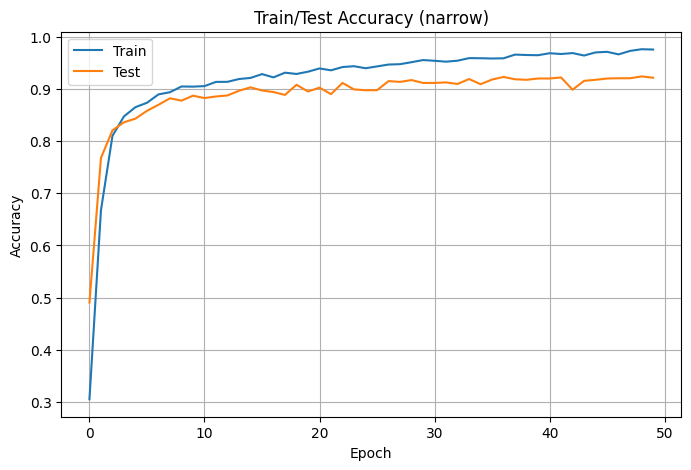

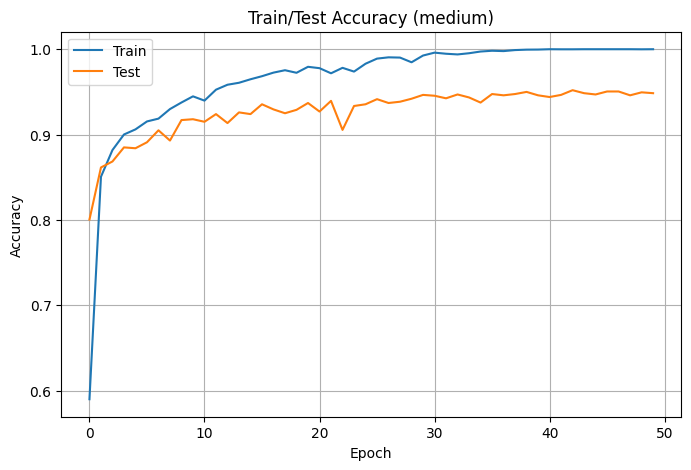

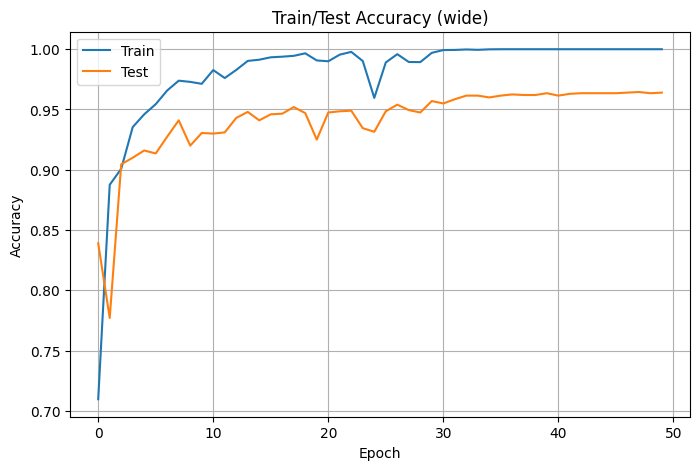

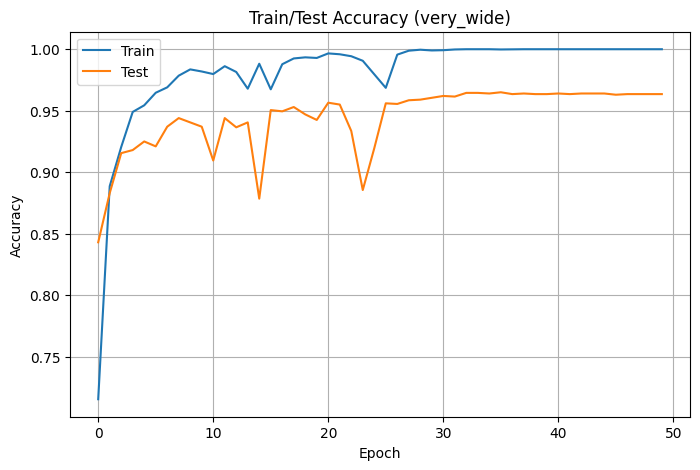


=== Summary of Width Experiments ===
narrow: max test acc=0.9245, params=53,018, time=105.5s
medium: max test acc=0.9520, params=242,762, time=104.8s
wide: max test acc=0.9645, params=1,462,538, time=104.6s
very_wide: max test acc=0.9650, params=4,235,786, time=105.4s


In [27]:
train_loader, test_loader = get_data_loaders(train_subset_size=10000, test_subset_size=2000)
print("=== Starting Width Experiments ===")
width_experiments(train_loader, test_loader)

### –ò–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –º–æ–∂–Ω–æ —Å–¥–µ–ª–∞—Ç—å –≤—ã–≤–æ–¥, —á—Ç–æ —á–µ–º —à–∏—Ä–µ —Å–µ—Ç—å, —Ç–µ–º –≤—ã—à–µ accuracy –∏ —Ç–µ–º –±–æ–ª—å—à–µ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤

In [ ]:
def build_layer_sizes(scheme, base_sizes):
    if scheme == 'expanding':
        return sorted(base_sizes)
    elif scheme == 'contracting':
        return sorted(base_sizes, reverse=True)
    elif scheme == 'constant':
        avg = int(np.mean(base_sizes))
        return [avg, avg, avg]
    else:
        raise ValueError("Unknown scheme")

In [39]:
def grid_search_architecture(train_loader, test_loader, base_widths, schemes=['expanding', 'contracting', 'constant']):
    criterion = nn.CrossEntropyLoss()
    results = {}

    for scheme in schemes:
        acc_matrix = np.zeros((len(base_widths), len(base_widths)))  # –ø—Ä–∏–º–µ—Ä –¥–ª—è 2D grid
        print(f"Scheme: {scheme}")
        
        seen_configs = set()  

        for i, w1 in enumerate(base_widths):
            for j, w2 in enumerate(base_widths):
                for k, w3 in enumerate(base_widths):
                    layer_sizes = [w1, w2, w3]
                    layer_sizes = build_layer_sizes(scheme, layer_sizes)

                    key = tuple(layer_sizes)  
                    if key in seen_configs:
                        continue  
                    seen_configs.add(key)

                    layers = []
                    for sz in layer_sizes:
                        layers.append({"type": "linear", "size": sz})
                        layers.append({"type": "relu"})
    
                    config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
                    model = FullyConnectedModel(**config).to(device)
                    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
                    start_time = time.time()
                    train_acc, test_acc, _, _ = train_model(model, train_loader, test_loader, EPOCHS, optimizer, criterion,
                                                            tag=f"{scheme}_{w1}_{w2}_{w3}")
                    elapsed = time.time() - start_time
    
                    print(f"Widths: {layer_sizes}, Test Acc: {test_acc[-1]:.4f}, Time: {elapsed:.1f}s")
                    acc_matrix[i, j] = test_acc[-1]

        results[scheme] = acc_matrix

    fig, axs = plt.subplots(1, len(schemes), figsize=(6 * len(schemes), 5))
    if len(schemes) == 1:
        axs = [axs]
    for ax, scheme in zip(axs, schemes):
        sns.heatmap(results[scheme], xticklabels=base_widths, yticklabels=base_widths, annot=True, fmt=".3f", ax=ax)
        ax.set_title(f"Scheme: {scheme}")
        ax.set_xlabel("Width 2")
        ax.set_ylabel("Width 1")
    plt.tight_layout()
    plt.show()

    return results


Using a subset of 2000 training samples.
Using a subset of 400 test samples.
Scheme: expanding
Widths: [32, 32, 32], Test Acc: 0.9125, Time: 21.6s
Widths: [32, 32, 64], Test Acc: 0.9175, Time: 21.2s
Widths: [32, 32, 128], Test Acc: 0.9100, Time: 21.4s
Widths: [32, 64, 64], Test Acc: 0.9175, Time: 21.4s
Widths: [32, 64, 128], Test Acc: 0.9250, Time: 20.8s
Widths: [32, 128, 128], Test Acc: 0.9300, Time: 20.8s
Widths: [64, 64, 64], Test Acc: 0.9025, Time: 20.8s
Widths: [64, 64, 128], Test Acc: 0.9200, Time: 20.8s
Widths: [64, 128, 128], Test Acc: 0.9225, Time: 20.8s
Widths: [128, 128, 128], Test Acc: 0.9325, Time: 20.9s
Scheme: contracting
Widths: [32, 32, 32], Test Acc: 0.9075, Time: 20.5s
Widths: [64, 32, 32], Test Acc: 0.9175, Time: 20.8s
Widths: [128, 32, 32], Test Acc: 0.8975, Time: 20.7s
Widths: [64, 64, 32], Test Acc: 0.9100, Time: 20.4s
Widths: [128, 64, 32], Test Acc: 0.9150, Time: 20.6s
Widths: [128, 128, 32], Test Acc: 0.9350, Time: 20.7s
Widths: [64, 64, 64], Test Acc: 0.9200,

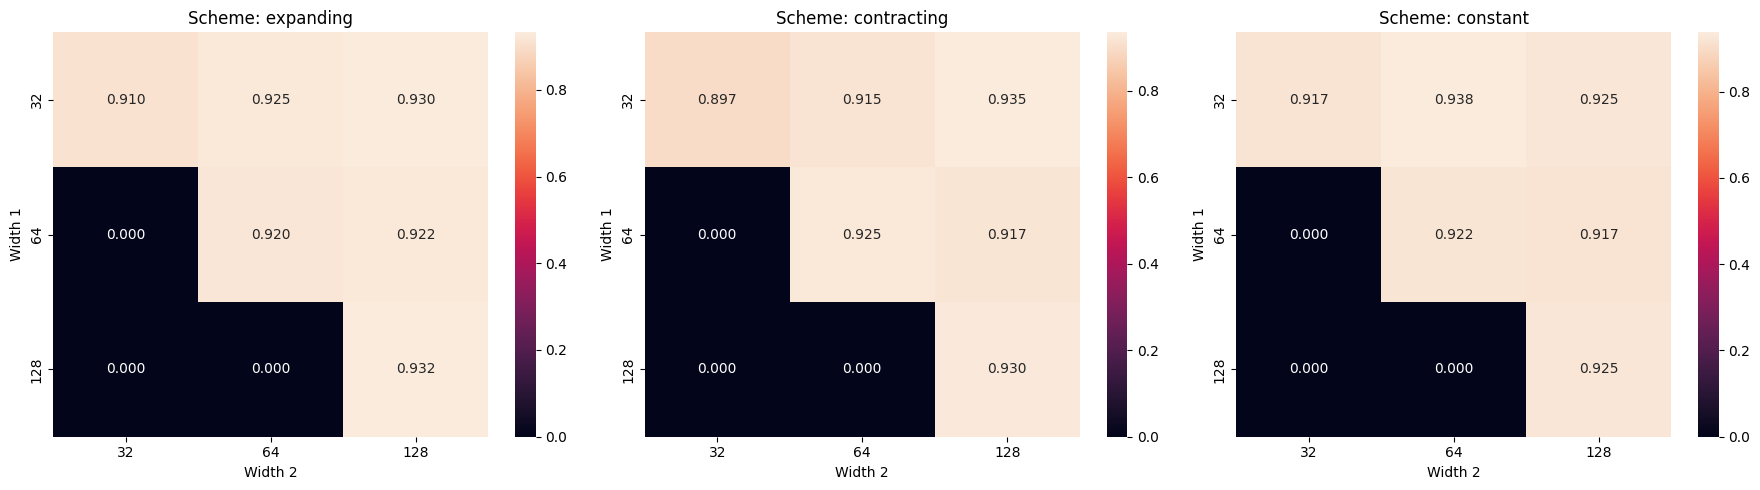

{'expanding': array([[0.91  , 0.925 , 0.93  ],
        [0.    , 0.92  , 0.9225],
        [0.    , 0.    , 0.9325]]),
 'contracting': array([[0.8975, 0.915 , 0.935 ],
        [0.    , 0.925 , 0.9175],
        [0.    , 0.    , 0.93  ]]),
 'constant': array([[0.9175, 0.9375, 0.925 ],
        [0.    , 0.9225, 0.9175],
        [0.    , 0.    , 0.925 ]])}

In [40]:
base_widths = [32, 64, 128]
train_loader, test_loader = get_data_loaders(train_subset_size=2000, test_subset_size=400)
grid_search_architecture(train_loader, test_loader, base_widths)

### –ö–∞–∫ –º–æ–∂–Ω–æ —É–≤–∏–¥–µ—Ç—å –≤ —Å—Ä–µ–¥–Ω–µ–º –¥–ª—è –¥–∞–Ω–Ω–æ–π –∑–∞–¥–∞—á–∏ —Ä–∞–∑–Ω—ã–µ —Å—Ö–µ–º—ã –∏–∑–º–µ–Ω–µ–Ω–∏—è —à–∏—Ä–∏–Ω—ã –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –ø—Ä–∏–º–µ—Ä–Ω–æ –æ–¥–∏–Ω–∞–∫–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è accuracy. –õ—É—á—à–µ–µ –∑–Ω–∞—á–µ–Ω–∏–µ –ø–æ–∫–∞–∑–∞–ª–æ —Å—Ö–µ–º–∞ 0.9375 (74,74,74) (–í–æ–∑–º–æ–∂–Ω–æ –¥–ª—è –≤—ã—è–≤–ª–µ–Ω–∏–∏ –ª—É—á—à–µ–π —Å—Ö–µ–º—ã –Ω—É–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å –±–æ–ª—å—à–µ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —ç–ø–æ—Ö –∏ –±–æ–ª—å—à—É—é —à–∏—Ä–∏–Ω—É)

## 3.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ç–µ—Ö–Ω–∏–∫ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏ (15 –±–∞–ª–ª–æ–≤)
``` python
# –ò—Å—Å–ª–µ–¥—É–π—Ç–µ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Ç–µ—Ö–Ω–∏–∫–∏ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏:
# - –ë–µ–∑ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏
# - –¢–æ–ª—å–∫–æ Dropout (—Ä–∞–∑–Ω—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã: 0.1, 0.3, 0.5)
# - –¢–æ–ª—å–∫–æ BatchNorm
# - Dropout + BatchNorm
# - L2 —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è (weight decay)
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –æ–¥–∏–Ω–∞–∫–æ–≤—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ñ–∏–Ω–∞–ª—å–Ω—É—é —Ç–æ—á–Ω–æ—Å—Ç—å
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–µ—Å–æ–≤
```

In [12]:
def regularization_experiments(train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    configs = {
        "no_reg": [],
        "dropout_0.1": [{"type": "dropout", "rate":0.1}],
        "dropout_0.3": [{"type": "dropout", "rate":0.3}],
        "dropout_0.5": [{"type": "dropout", "rate":0.5}],
        "batch_norm": [{"type": "batch_norm"}],
        "dropout+batch_norm": [{"type": "batch_norm"}, {"type": "dropout", "rate":0.3}],
    }
    arch_base = [256, 128, 64]
    results = []

    for tag, extra_layers in configs.items():
        layers = []
        for size in arch_base:
            layers.append({"type": "linear", "size": size})
            layers.append({"type": "relu"})
            layers.extend(extra_layers)  
        config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
        model = FullyConnectedModel(**config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE,
                               weight_decay=1e-4 if "l2" in tag else 0.0)
        train_acc, test_acc, train_loss, test_loss = train_model(
            model, train_loader, test_loader, EPOCHS, optimizer, criterion, tag)
        plot_curves(train_acc, test_acc, 'Accuracy', f'Train/Test Accuracy ({tag})')
        max_test_acc = max(test_acc)
        results.append((tag, max_test_acc))
        last_weight = list(model.parameters())[-2].detach().cpu().numpy().flatten()
        plt.figure()
        sns.histplot(last_weight, bins=50, kde=True)
        plt.title(f"Weight distribution ({tag})")
        plt.show()

    print("\n=== Summary of Regularization Experiments ===")
    for tag, acc in results:
        print(f"{tag}: max test acc={acc:.4f}")

100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 9.91M/9.91M [00:00<00:00, 59.5MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 28.9k/28.9k [00:00<00:00, 1.69MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 1.65M/1.65M [00:00<00:00, 14.8MB/s]
100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 4.54k/4.54k [00:00<00:00, 7.08MB/s]


Using a subset of 10000 training samples.
Using a subset of 2000 test samples.


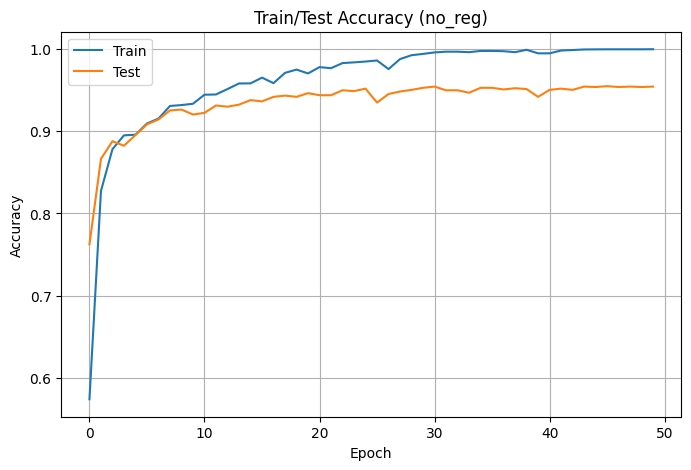

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


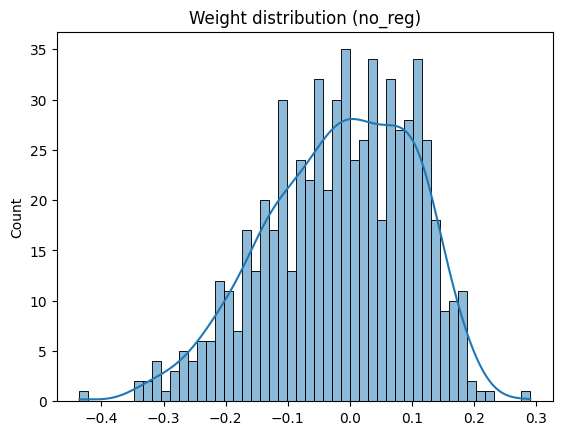

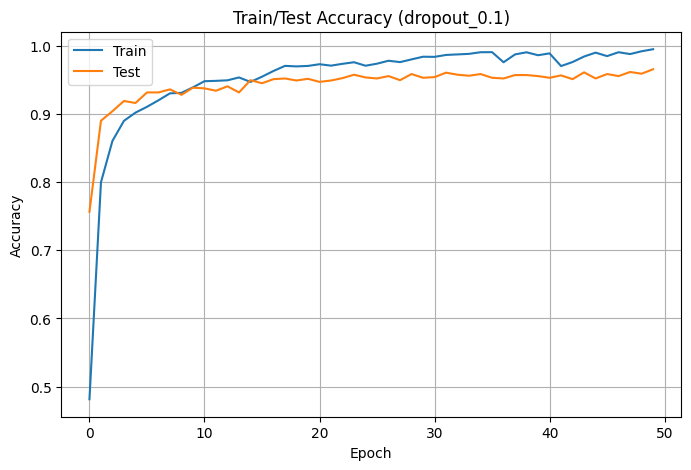

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


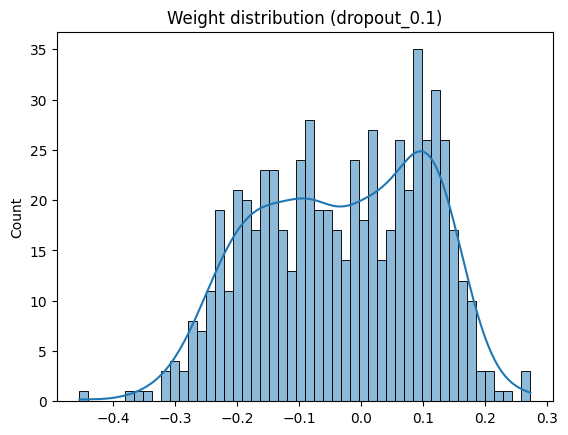

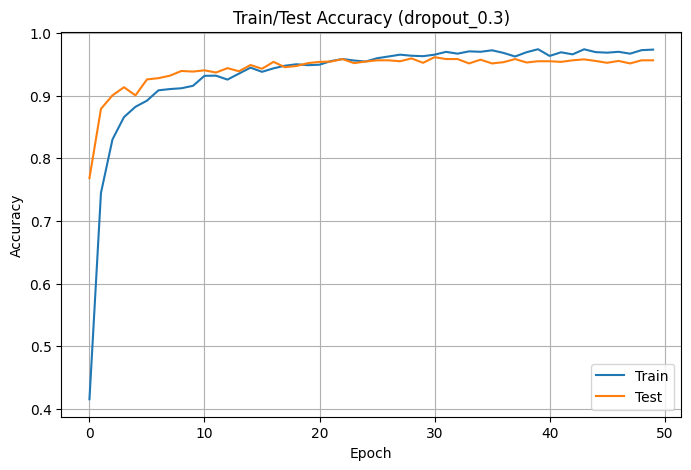

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


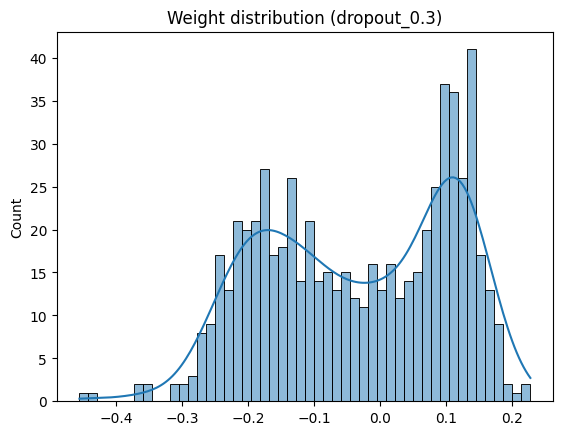

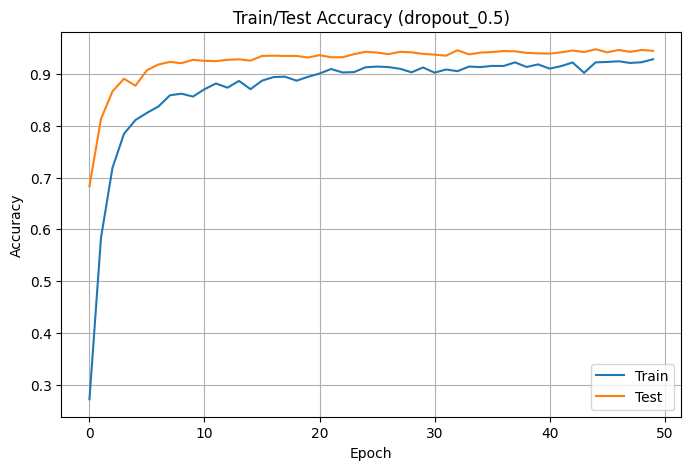

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


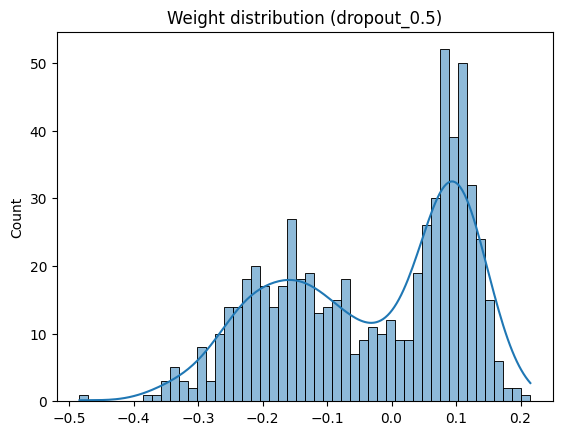

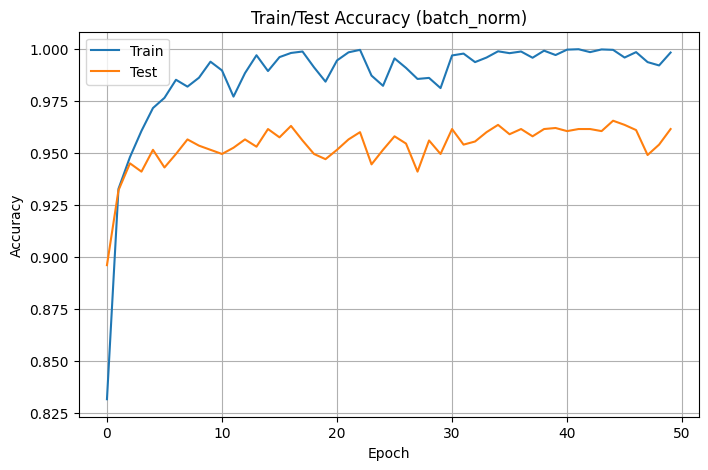

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


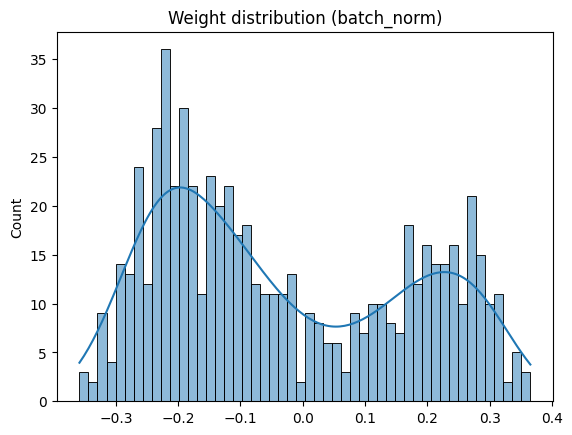

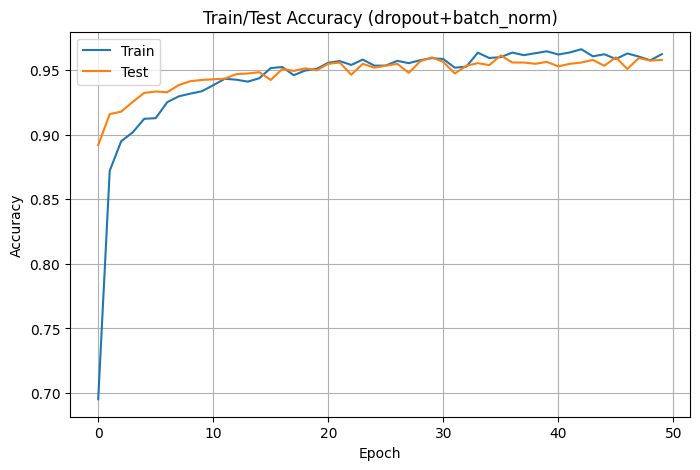

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


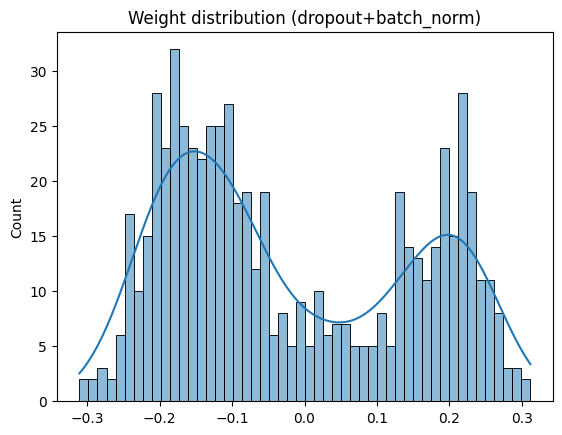


=== Summary of Regularization Experiments ===
no_reg: max test acc=0.9550
dropout_0.1: max test acc=0.9655
dropout_0.3: max test acc=0.9615
dropout_0.5: max test acc=0.9480
batch_norm: max test acc=0.9655
dropout+batch_norm: max test acc=0.9615


In [13]:
train_loader, test_loader = get_data_loaders(train_subset_size=10000, test_subset_size=2000)
regularization_experiments(train_loader, test_loader)

### –ò–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ –≤–∏–¥–Ω–æ, —á—Ç–æ –ª—É—á—à–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø–æ–∫–∞–∑—ã–≤–∞—é—Ç –º–æ–¥–µ–ª–∏ —Å dropout 0.1 –∏ batch_norm c accuracy 0.9655

## 3.2 –ê–¥–∞–ø—Ç–∏–≤–Ω–∞—è —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è (10 –±–∞–ª–ª–æ–≤)
``` python
# –†–µ–∞–ª–∏–∑—É–π—Ç–µ –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–µ —Ç–µ—Ö–Ω–∏–∫–∏:
# - Dropout —Å –∏–∑–º–µ–Ω—è—é—â–∏–º—Å—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º
# - BatchNorm —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ momentum
# - –ö–æ–º–±–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —Ç–µ—Ö–Ω–∏–∫
# - –ê–Ω–∞–ª–∏–∑ –≤–ª–∏—è–Ω–∏—è –Ω–∞ —Ä–∞–∑–Ω—ã–µ —Å–ª–æ–∏ —Å–µ—Ç–∏
```

In [18]:
def adaptive_regularization(train_loader, test_loader):
    criterion = nn.CrossEntropyLoss()
    arch = [256, 128, 64]

    dropouts = [0.1, 0.3, 0.5]
    bn_momentums = [0.1, 0.5, 0.9]

    layers = []
    for i, size in enumerate(arch):
        layers.append({"type": "linear", "size": size})
        layers.append({"type": "batch_norm"})
        layers.append({"type": "relu"})
        layers.append({"type": "dropout", "rate": dropouts[i]})

    config = {"input_size": INPUT_DIM, "num_classes": OUTPUT_DIM, "layers": layers}
    model = FullyConnectedModel(**config).to(device)

    bn_idx = 0
    for m in model.modules():
        if isinstance(m, nn.BatchNorm1d):
            m.momentum = bn_momentums[bn_idx]
            bn_idx += 1

    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    train_acc, test_acc, train_loss, test_loss = train_model(
        model, train_loader, test_loader, EPOCHS, optimizer, criterion, tag="adaptive_reg")

    plot_curves(train_acc, test_acc, 'Accuracy', 'Train/Test Accuracy (Adaptive Reg)')
    plot_curves(train_loss, test_loss, 'Loss', 'Train/Test Loss (Adaptive Reg)')

    max_test_acc = max(test_acc)
    print("\n=== Adaptive regularization results ===")
    print(f"Dropout rates: {dropouts}")
    print(f"BatchNorm momentums: {bn_momentums}")
    print(f"Max test accuracy: {max_test_acc:.4f}")

    weights = []
    for name, param in model.named_parameters():
        if 'weight' in name:
            weights.append(param.data.cpu().numpy().flatten())
    weights = np.concatenate(weights)

    plt.figure(figsize=(8, 4))
    plt.hist(weights, bins=100, alpha=0.7)
    plt.title("Weight distribution after training (Adaptive Reg)")
    plt.xlabel("Weight value")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Using a subset of 5000 training samples.
Using a subset of 1000 test samples.


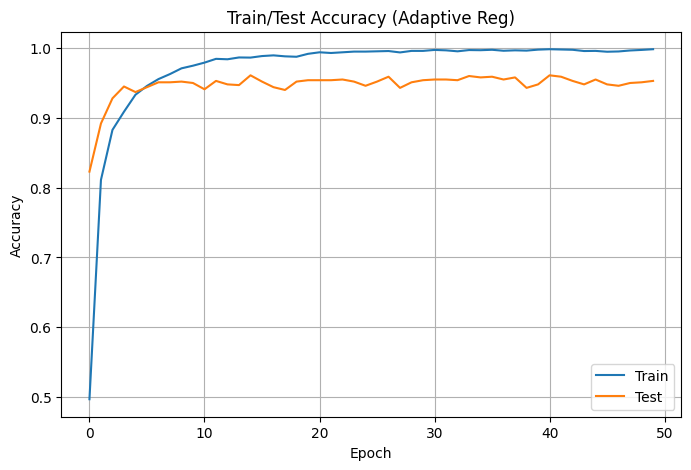

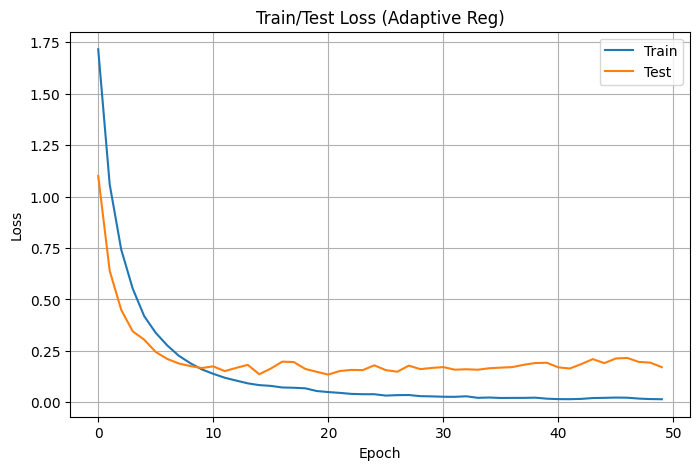


=== Adaptive regularization results ===
Dropout rates: [0.1, 0.3, 0.5]
BatchNorm momentums: [0.1, 0.5, 0.9]
Max test accuracy: 0.9610


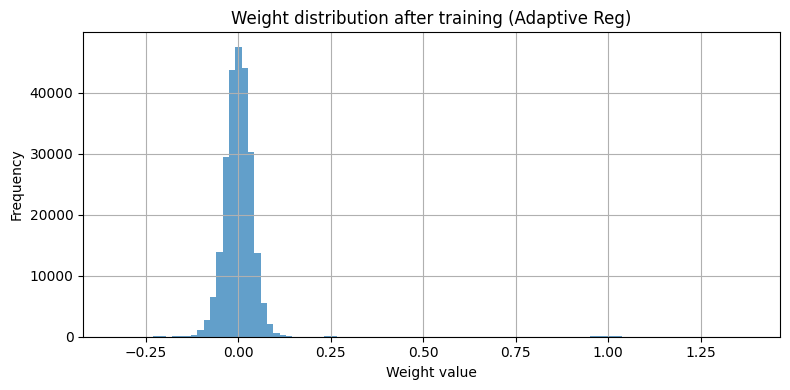

In [21]:
train_loader, test_loader = get_data_loaders(train_subset_size=5000, test_subset_size=1000)
adaptive_regularization(train_loader, test_loader)

### –†–µ–∞–ª–∏–∑–æ–≤–∞–ª —Å–µ—Ç—å —Å —Ä–∞–∑–Ω—ã–º–∏ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞–º–∏ dropout –∏ momemtun batchnorm.(–ø–æ –∑–∞–¥–∞–Ω–∏—é 3.2) Accuracy —Å–æ –≤—Ä–µ–º–µ–Ω–µ–º —Ä–∞—Å—Ç–µ—Ç, loss –ø–∞–¥–∞–µ—Ç. –ü—Ä–∏–º–µ—Ä–Ω–æ –Ω–∞ 10 —ç–ø–æ—Ö–µ –∏ loss –∏ accuracy –ø–µ—Ä–µ—Å—Ç–∞—é—Ç —Å–∏–ª—å–Ω–æ —É–ª—É—á—à–∞—Ç—å—Å—è(–º–æ–∂–Ω–æ –∏—Å–ø–æ–ª—å–∑–æ–≤–∞—Ç—å 10-15 —ç–ø–æ—Ö). –í–µ—Å–∞ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è—é—Ç –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–æ —Å—Ä–µ–¥–Ω–∏–º –≤ 0.

# –î–æ–º–∞—à–Ω–µ–µ –∑–∞–¥–∞–Ω–∏–µ –∫ —É—Ä–æ–∫—É 3: –ü–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã–µ —Å–µ—Ç–∏

## –¶–µ–ª—å –∑–∞–¥–∞–Ω–∏—è
–ò–∑—É—á–∏—Ç—å –≤–ª–∏—è–Ω–∏–µ –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã –ø–æ–ª–Ω–æ—Å–≤—è–∑–Ω—ã—Ö —Å–µ—Ç–µ–π –Ω–∞ –∫–∞—á–µ—Å—Ç–≤–æ –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ü–∏–∏, –ø—Ä–æ–≤–µ—Å—Ç–∏ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è–º–∏ –º–æ–¥–µ–ª–µ–π.

## –ó–∞–¥–∞–Ω–∏–µ 1: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å –≥–ª—É–±–∏–Ω–æ–π —Å–µ—Ç–∏ (30 –±–∞–ª–ª–æ–≤)

–°–æ–∑–¥–∞–π—Ç–µ —Ñ–∞–π–ª `homework_depth_experiments.py`:

### 1.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Ä–∞–∑–Ω–æ–π –≥–ª—É–±–∏–Ω—ã (15 –±–∞–ª–ª–æ–≤)
```python
# –°–æ–∑–¥–∞–π—Ç–µ –∏ –æ–±—É—á–∏—Ç–µ –º–æ–¥–µ–ª–∏ —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —Å–ª–æ–µ–≤:
# - 1 —Å–ª–æ–π (–ª–∏–Ω–µ–π–Ω—ã–π –∫–ª–∞—Å—Å–∏—Ñ–∏–∫–∞—Ç–æ—Ä)
# - 2 —Å–ª–æ—è (1 —Å–∫—Ä—ã—Ç—ã–π)
# - 3 —Å–ª–æ—è (2 —Å–∫—Ä—ã—Ç—ã—Ö)
# - 5 —Å–ª–æ–µ–≤ (4 —Å–∫—Ä—ã—Ç—ã—Ö)
# - 7 —Å–ª–æ–µ–≤ (6 —Å–∫—Ä—ã—Ç—ã—Ö)
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ç–æ—á–Ω–æ—Å—Ç—å –Ω–∞ train –∏ test
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –∫—Ä–∏–≤—ã–µ –æ–±—É—á–µ–Ω–∏—è
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
```

### 1.2 –ê–Ω–∞–ª–∏–∑ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è (15 –±–∞–ª–ª–æ–≤)
```python
# –ò—Å—Å–ª–µ–¥—É–π—Ç–µ –≤–ª–∏—è–Ω–∏–µ –≥–ª—É–±–∏–Ω—ã –Ω–∞ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ:
# - –ü–æ—Å—Ç—Ä–æ–π—Ç–µ –≥—Ä–∞—Ñ–∏–∫–∏ train/test accuracy –ø–æ —ç–ø–æ—Ö–∞–º
# - –û–ø—Ä–µ–¥–µ–ª–∏—Ç–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é –≥–ª—É–±–∏–Ω—É –¥–ª—è –∫–∞–∂–¥–æ–≥–æ –¥–∞—Ç–∞—Å–µ—Ç–∞
# - –î–æ–±–∞–≤—å—Ç–µ Dropout –∏ BatchNorm, —Å—Ä–∞–≤–Ω–∏—Ç–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ, –∫–æ–≥–¥–∞ –Ω–∞—á–∏–Ω–∞–µ—Ç—Å—è –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ
```

## –ó–∞–¥–∞–Ω–∏–µ 2: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å —à–∏—Ä–∏–Ω–æ–π —Å–µ—Ç–∏ (25 –±–∞–ª–ª–æ–≤)

–°–æ–∑–¥–∞–π—Ç–µ —Ñ–∞–π–ª `homework_width_experiments.py`:

### 2.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ –º–æ–¥–µ–ª–µ–π —Ä–∞–∑–Ω–æ–π —à–∏—Ä–∏–Ω—ã (15 –±–∞–ª–ª–æ–≤)
```python
# –°–æ–∑–¥–∞–π—Ç–µ –º–æ–¥–µ–ª–∏ —Å —Ä–∞–∑–ª–∏—á–Ω–æ–π —à–∏—Ä–∏–Ω–æ–π —Å–ª–æ–µ–≤:
# - –£–∑–∫–∏–µ —Å–ª–æ–∏: [64, 32, 16]
# - –°—Ä–µ–¥–Ω–∏–µ —Å–ª–æ–∏: [256, 128, 64]
# - –®–∏—Ä–æ–∫–∏–µ —Å–ª–æ–∏: [1024, 512, 256]
# - –û—á–µ–Ω—å —à–∏—Ä–æ–∫–∏–µ —Å–ª–æ–∏: [2048, 1024, 512]
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –ü–æ–¥–¥–µ—Ä–∂–∏–≤–∞–π—Ç–µ –æ–¥–∏–Ω–∞–∫–æ–≤—É—é –≥–ª—É–±–∏–Ω—É (3 —Å–ª–æ—è)
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ç–æ—á–Ω–æ—Å—Ç—å –∏ –≤—Ä–µ–º—è –æ–±—É—á–µ–Ω–∏—è
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤
```

### 2.2 –û–ø—Ç–∏–º–∏–∑–∞—Ü–∏—è –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—ã (10 –±–∞–ª–ª–æ–≤)
```python
# –ù–∞–π–¥–∏—Ç–µ –æ–ø—Ç–∏–º–∞–ª—å–Ω—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É:
# - –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ grid search –¥–ª—è –ø–æ–∏—Å–∫–∞ –ª—É—á—à–µ–π –∫–æ–º–±–∏–Ω–∞—Ü–∏–∏
# - –ü–æ–ø—Ä–æ–±—É–π—Ç–µ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Å—Ö–µ–º—ã –∏–∑–º–µ–Ω–µ–Ω–∏—è —à–∏—Ä–∏–Ω—ã (—Ä–∞—Å—à–∏—Ä–µ–Ω–∏–µ, —Å—É–∂–µ–Ω–∏–µ, –ø–æ—Å—Ç–æ—è–Ω–Ω–∞—è)
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –≤ –≤–∏–¥–µ heatmap
```

## –ó–∞–¥–∞–Ω–∏–µ 3: –≠–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç—ã —Å —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–µ–π (25 –±–∞–ª–ª–æ–≤)

–°–æ–∑–¥–∞–π—Ç–µ —Ñ–∞–π–ª `homework_regularization_experiments.py`:

### 3.1 –°—Ä–∞–≤–Ω–µ–Ω–∏–µ —Ç–µ—Ö–Ω–∏–∫ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏ (15 –±–∞–ª–ª–æ–≤)
```python
# –ò—Å—Å–ª–µ–¥—É–π—Ç–µ —Ä–∞–∑–ª–∏—á–Ω—ã–µ —Ç–µ—Ö–Ω–∏–∫–∏ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏:
# - –ë–µ–∑ —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏–∏
# - –¢–æ–ª—å–∫–æ Dropout (—Ä–∞–∑–Ω—ã–µ –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç—ã: 0.1, 0.3, 0.5)
# - –¢–æ–ª—å–∫–æ BatchNorm
# - Dropout + BatchNorm
# - L2 —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è (weight decay)
#
# –î–ª—è –∫–∞–∂–¥–æ–≥–æ –≤–∞—Ä–∏–∞–Ω—Ç–∞:
# - –ò—Å–ø–æ–ª—å–∑—É–π—Ç–µ –æ–¥–∏–Ω–∞–∫–æ–≤—É—é –∞—Ä—Ö–∏—Ç–µ–∫—Ç—É—Ä—É
# - –°—Ä–∞–≤–Ω–∏—Ç–µ —Ñ–∏–Ω–∞–ª—å–Ω—É—é —Ç–æ—á–Ω–æ—Å—Ç—å
# - –ü—Ä–æ–∞–Ω–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Å—Ç–∞–±–∏–ª—å–Ω–æ—Å—Ç—å –æ–±—É—á–µ–Ω–∏—è
# - –í–∏–∑—É–∞–ª–∏–∑–∏—Ä—É–π—Ç–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–µ—Å–æ–≤
```

### 3.2 –ê–¥–∞–ø—Ç–∏–≤–Ω–∞—è —Ä–µ–≥—É–ª—è—Ä–∏–∑–∞—Ü–∏—è (10 –±–∞–ª–ª–æ–≤)
```python
# –†–µ–∞–ª–∏–∑—É–π—Ç–µ –∞–¥–∞–ø—Ç–∏–≤–Ω—ã–µ —Ç–µ—Ö–Ω–∏–∫–∏:
# - Dropout —Å –∏–∑–º–µ–Ω—è—é—â–∏–º—Å—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–æ–º
# - BatchNorm —Å —Ä–∞–∑–ª–∏—á–Ω—ã–º–∏ momentum
# - –ö–æ–º–±–∏–Ω–∏—Ä–æ–≤–∞–Ω–∏–µ –Ω–µ—Å–∫–æ–ª—å–∫–∏—Ö —Ç–µ—Ö–Ω–∏–∫
# - –ê–Ω–∞–ª–∏–∑ –≤–ª–∏—è–Ω–∏—è –Ω–∞ —Ä–∞–∑–Ω—ã–µ —Å–ª–æ–∏ —Å–µ—Ç–∏
```

## –î–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω—ã–µ —Ç—Ä–µ–±–æ–≤–∞–Ω–∏—è

1. **–ö–æ–¥ –¥–æ–ª–∂–µ–Ω –±—ã—Ç—å –º–æ–¥—É–ª—å–Ω—ã–º** - —Å–æ–∑–¥–∞–π—Ç–µ –æ—Ç–¥–µ–ª—å–Ω—ã–µ —Ñ—É–Ω–∫—Ü–∏–∏ –¥–ª—è –∫–∞–∂–¥–æ–≥–æ —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–∞
2. **–í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è** - —Å–æ–∑–¥–∞–π—Ç–µ –∏–Ω—Ñ–æ—Ä–º–∞—Ç–∏–≤–Ω—ã–µ –≥—Ä–∞—Ñ–∏–∫–∏ –∏ –¥–∏–∞–≥—Ä–∞–º–º—ã
3. **–î–æ–∫—É–º–µ–Ω—Ç–∞—Ü–∏—è** - –¥–æ–±–∞–≤—å—Ç–µ –ø–æ–¥—Ä–æ–±–Ω—ã–µ –∫–æ–º–º–µ–Ω—Ç–∞—Ä–∏–∏ –∏ –∞–Ω–∞–ª–∏–∑ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
4. **–¢–µ—Å—Ç–∏—Ä–æ–≤–∞–Ω–∏–µ** - –ø—Ä–æ–≤–µ—Ä—å—Ç–µ –∫–æ—Ä—Ä–µ–∫—Ç–Ω–æ—Å—Ç—å —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–æ–≤ –Ω–∞ –ø—Ä–æ—Å—Ç—ã—Ö –ø—Ä–∏–º–µ—Ä–∞—Ö
5. **–õ–æ–≥–∏—Ä–æ–≤–∞–Ω–∏–µ** - –∏—Å–ø–æ–ª—å–∑—É–π—Ç–µ logging –¥–ª—è –æ—Ç—Å–ª–µ–∂–∏–≤–∞–Ω–∏—è —ç–∫—Å–ø–µ—Ä–∏–º–µ–Ω—Ç–æ–≤

## –°—Ç—Ä—É–∫—Ç—É—Ä–∞ –ø—Ä–æ–µ–∫—Ç–∞

```
homework/
‚îú‚îÄ‚îÄ homework_depth_experiments.py
‚îú‚îÄ‚îÄ homework_width_experiments.py
‚îú‚îÄ‚îÄ homework_regularization_experiments.py
‚îú‚îÄ‚îÄ utils/
‚îÇ   ‚îú‚îÄ‚îÄ experiment_utils.py
‚îÇ   ‚îú‚îÄ‚îÄ visualization_utils.py
‚îÇ   ‚îî‚îÄ‚îÄ model_utils.py
‚îú‚îÄ‚îÄ results/
‚îÇ   ‚îú‚îÄ‚îÄ depth_experiments/
‚îÇ   ‚îú‚îÄ‚îÄ width_experiments/
‚îÇ   ‚îî‚îÄ‚îÄ regularization_experiments/
‚îú‚îÄ‚îÄ plots/                   # –ì—Ä–∞—Ñ–∏–∫–∏ –∏ –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
‚îî‚îÄ‚îÄ README.md               # –û–ø–∏—Å–∞–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤
```

## –°—Ä–æ–∫ —Å–¥–∞—á–∏
–î–æ–º–∞—à–Ω–µ–µ –∑–∞–¥–∞–Ω–∏–µ –¥–æ–ª–∂–Ω–æ –±—ã—Ç—å –≤—ã–ø–æ–ª–Ω–µ–Ω–æ –¥–æ –Ω–∞—á–∞–ª–∞ –∑–∞–Ω—è—Ç–∏—è 5.

## –ü–æ–ª–µ–∑–Ω—ã–µ —Å—Å—ã–ª–∫–∏
- [PyTorch nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html)
- [PyTorch Dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html)
- [PyTorch BatchNorm](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- [Understanding Dropout](https://jmlr.org/papers/v15/srivastava14a.html)

–£–¥–∞—á–∏ –≤ –≤—ã–ø–æ–ª–Ω–µ–Ω–∏–∏ –∑–∞–¥–∞–Ω–∏—è! üöÄ